# Importing Important Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.tokenizer import Tokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import pandas as pd
from bs4 import BeautifulSoup

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Loading and Reading the Dataset

In [ ]:
dataset = pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')

In [ ]:
class_distribution = dataset['Label'].value_counts()
print(class_distribution)

Label
0    7466
1    7466
Name: count, dtype: int64


# Posts Preprocessing

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
#Applying heuristic techinques to reduce noice in the data
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    for table in soup.find_all('table'):
        table.replace_with('[table]')

    clean_text = soup.get_text()

    return clean_text

dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)

# Print sample cleaned data
print(dataset[['Question_body', 'Question_body_cleaned']].head())

                                       Question_body  \
0  <p>When deploying a Windows EC2 instance with ...   
1  I'm pretty new to my company (2 weeks) and we'...   
2  <p>I am trying to figure out how to get <code>...   
3  Say you have an application divided into 3-tie...   
4  <p>I am trying to use the circuit breaker patt...   

                               Question_body_cleaned  
0  When deploying a Windows EC2 instance with Ter...  
1  I'm pretty new to my company (2 weeks) and we'...  
2  I am trying to figure out how to get [code-sni...  
3  Say you have an application divided into 3-tie...  
4  I am trying to use the circuit breaker pattern...  


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)

    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

dataset['Question_body_cleaned'] = dataset['Question_body_cleaned'].fillna('').astype(str)

# Apply the preprocessing function
dataset['Question_body_preprocessed'] = dataset['Question_body_cleaned'].apply(preprocess_text)


In [ ]:
# Preprocess the data for TextCNN
X = dataset['Question_body_preprocessed']
y = dataset['Label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

## Split the data

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Parameters
vocab_size = 5000
embedding_dim = 200
max_length = 500
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Define TextCNN model


In [ ]:
def model(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)

    conv1 = Conv1D(128, 3, activation='relu')(embedding)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 4, activation='relu')(embedding)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, 5, activation='relu')(embedding)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    concatenated = concatenate([pool1, pool2, pool3], axis=1)
    flatten = Flatten()(concatenated)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## Create the model

In [ ]:
# Create the model
text_cnn_model = create_text_cnn_model(vocab_size, embedding_dim, max_length)

## Display the model summary

In [ ]:
# Display the model summary
text_cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 100)       │        500,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 498, 128)       │         38,528 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 497, 128)       │         51,328 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 496, 128)       │         64,128 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 249, 128)       │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 248, 128)       │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 248, 128)       │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 745, 128)       │              0 │ max_pooling1d[0][0],   │
│                           │                        │                │ max_pooling1d_1[0][0], │
│                           │                        │                │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 95360)          │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │     12,206,208 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,860,321 (49.06 MB)

 Trainable params: 12,860,321 (49.06 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = text_cnn_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = text_cnn_model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 242s 638ms/step - accuracy: 0.8118 - loss: 0.3809 - val_accuracy: 0.9387 - val_loss: 0.1645
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 254s 678ms/step - accuracy: 0.9675 - loss: 0.0967 - val_accuracy: 0.9478 - val_loss: 0.1723
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 255s 660ms/step - accuracy: 0.9837 - loss: 0.0588 - val_accuracy: 0.9394 - val_loss: 0.2081
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 265s 668ms/step - accuracy: 0.9894 - loss: 0.0333 - val_accuracy: 0.9327 - val_loss: 0.3143
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 235s 629ms/step - accuracy: 0.9956 - loss: 0.0161 - val_accuracy: 0.9320 - val_loss: 0.3313
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 271s 653ms/step - accuracy: 0.9943 - loss: 0.0175 - val_accuracy: 0.9327 - val_loss: 0.3675
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 253s 628ms/step - accuracy: 0.9977 - loss: 0.0077 - val_accuracy: 0.9391 - val_loss: 0.4508
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 273s 658ms/step - accuracy: 0.9963 -

# Evaluate the model

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Predict on new data
y_pred = text_cnn_model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

y_true_classes = y_test

# Compute precision, recall, f1-score, and accuracy (overall)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_classes, average='binary')
overall_accuracy = accuracy_score(y_test, y_pred_classes)

# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step
Overall Precision: 0.9372013651877134
Overall Recall: 0.9214765100671141
Overall F1-score: 0.9292724196277495
Overall Accuracy: 0.9300301305657851


## Prediction results analysis with Confusion Matrix

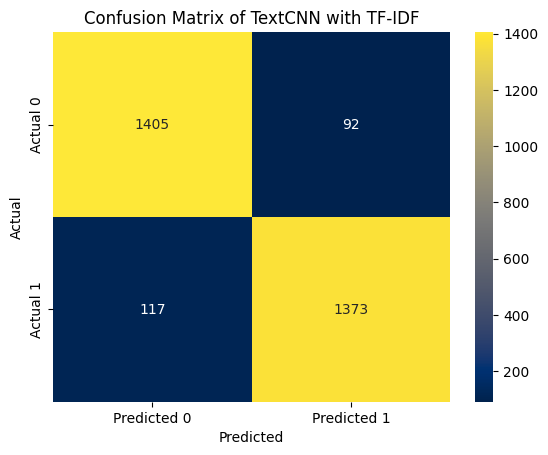

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true_classes = y_test

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of TextCNN with TF-IDF')
plt.show()
